# Lab 08

In [1]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt

from utils.plotting import draw_degree_histogram, get_context_for_dark_IDE, pretty_draw
from utils.analysis import get_basic_parameters_table, display_pandas_table
from utils.graph_import import read_mtx, read_got_graph

## Hierarchy

In [2]:
def plot_hierarchy_check(graph: nx.Graph):
    max_dgr = max(dict(graph.degree).values())
    X = [x for x in range(max_dgr+1)]
    adc = nx.algorithms.clustering(graph)
    Y = { k:0 for k in X}
    for v in graph.nodes:
        v_dgr = graph.degree(v)
        Y[v_dgr] += adc[v]
    adc_x, adc_y = zip(*sorted(Y.items()))
    Y_teor = [1/(x+(1e-12)) for x in X]
    plt.plot(X, Y_teor)
    plt.plot(adc_x, adc_y, 'bo')
    plt.xscale('log')
    plt.yscale('log')

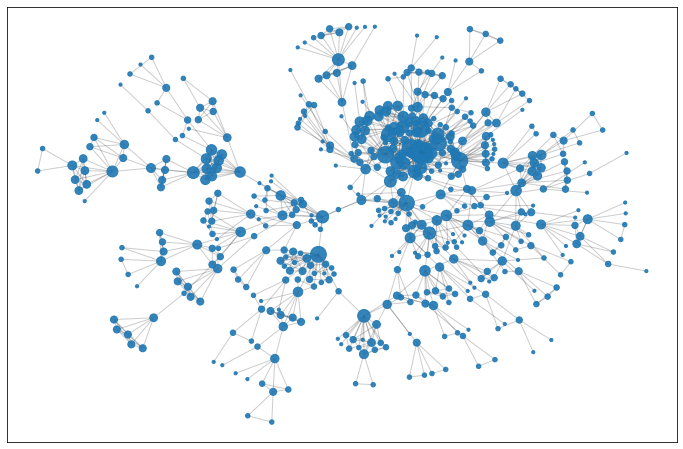

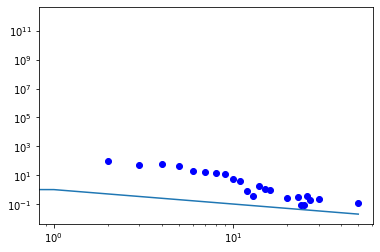

In [3]:
bio_dis = read_mtx('../data/bio-diseasome/bio-diseasome.mtx')

# noinspection JupyterKernel
with get_context_for_dark_IDE():
    pretty_draw(bio_dis)
    plt.show()

with get_context_for_dark_IDE():
    plot_hierarchy_check(bio_dis)

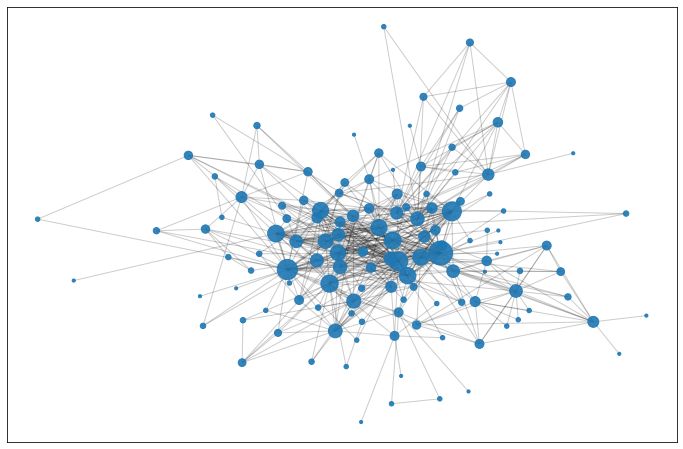

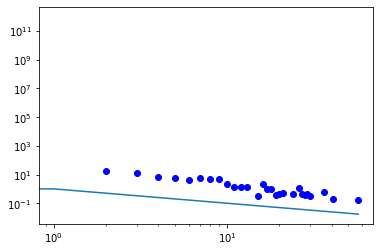

In [4]:
got_s1 = read_got_graph('../data/got/got-s1-edges.csv')

with get_context_for_dark_IDE():
    pretty_draw(got_s1)
    plt.show()

with get_context_for_dark_IDE():
    plot_hierarchy_check(got_s1)

## ZTM

In [5]:
def remove_nodes_without_position(graph, stops):
    nodes_idxs = set([s['id'] for s in stops])
    graph.remove_nodes_from([s for s in graph.nodes if s not in nodes_idxs])
    return graph

def remove_nodes_with_degree_zero(graph):
    return graph.subgraph([v for v in graph.nodes if graph.degree(v) > 0])

### Daily

In [6]:
with open('../data/ZTM/layers/stops.json', 'r', encoding='utf-8') as f:
    stops = json.load(f)

with open('../data/ZTM/layers/edges.json', 'r', encoding='utf-8') as f:
    edges = json.load(f)

transport_types = ['bus', 'train', 'tram']
ZTM = [nx.DiGraph(name=t) for t in transport_types]

for i, g in enumerate(ZTM):
    g.add_nodes_from([(s['id'], s) for s in stops])
    type_edges = [e for e in edges if e['transport'] == g.name][0]
    g.add_edges_from([(e['from'], e['to'], {'weight': e['weight']}) for e in type_edges['edge']])
    g = remove_nodes_without_position(g, stops)
    ZTM[i] = remove_nodes_with_degree_zero(g)


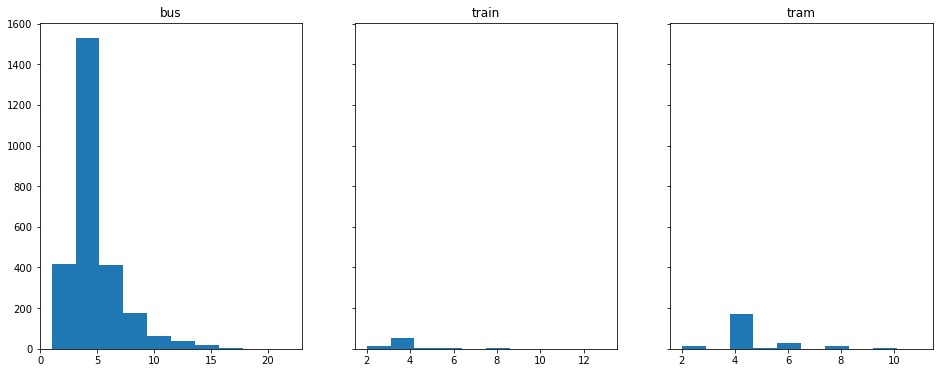

In [7]:
with get_context_for_dark_IDE():
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,6))
    for i, g in enumerate(ZTM):
        draw_degree_histogram(g, ax=axs[i], white_ticks=False)
        axs[i].set_title(g.name)


In [8]:
ZTM_merged = nx.compose_all(ZTM)
ZTM_merged.name = 'merged'
table = get_basic_parameters_table([g.to_undirected() for g in [*ZTM, ZTM_merged]])
display_pandas_table(table)

     name direct     N     E   <k> alpha     r
0     bus  False  2662  3768  2.83  3.23  0.24
1   train  False    83    92  2.22  2.83  0.17
2    tram  False   238   292  2.45  2.27  0.15
3  merged  False  2780  3963  2.85  3.29  0.24

### Hourly

In [9]:
with open('../data/ZTM/layers/stops.json', 'r', encoding='utf-8') as f:
    stops = json.load(f)

with open('../data/ZTM/layers/time_edges.json', 'r', encoding='utf-8') as f:
    edges = json.load(f)

transport_types = ['bus', 'train', 'tram']
hours = [i for i in range(24)]
ZTM = {t: [nx.DiGraph(name=f'{t}_{h}') for h in hours] for t in transport_types}

for t, g_hours in ZTM.items():
    for i, g in enumerate(g_hours):
        g.add_nodes_from([(s['id'], s) for s in stops])
        hour_edges = [edg['graphs'] for edg in edges if edg['hour'] == i][0]
        type_edges = [e for e in hour_edges if e['transport'] == t]
        if len(type_edges) > 0:
            g.add_edges_from([(e['from'], e['to'], {'weight': e['weight']}) for e in type_edges[0]['edge']])
            g = remove_nodes_without_position(g, stops)
            g_hours[i] = remove_nodes_with_degree_zero(g)

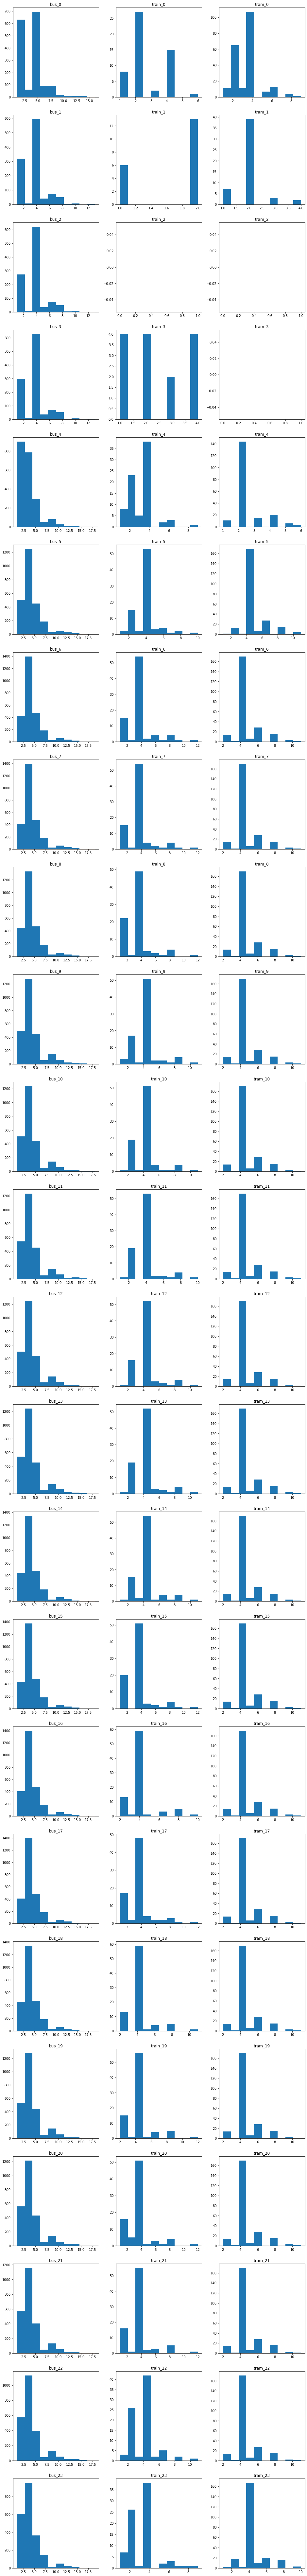

In [10]:
with get_context_for_dark_IDE():
    fig, axs = plt.subplots(nrows=24, ncols=3, figsize=(16, 144))
    for t, g_hours in enumerate(ZTM.values()):
        for i, g in enumerate(g_hours):
            g_sub = g.subgraph([v for v in g.nodes if g.degree(v)>0])
            draw_degree_histogram(g_sub, ax=axs[i, t], white_ticks=False)
            axs[i, t].set_title(g.name)

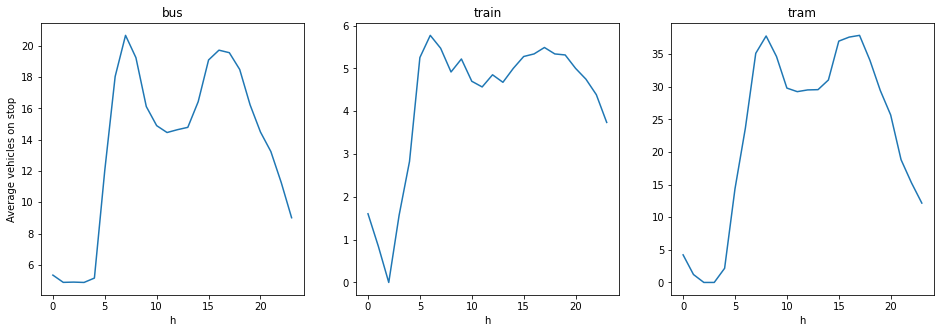

In [11]:
X = [h for h in range(24)]
with get_context_for_dark_IDE():
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    axs[0].set_ylabel('Average vehicles on stop')
    for t, (transport_type, g_hours) in enumerate(ZTM.items()):
        y = [sum([e['weight'] for u, v, e in g.edges(data=True)])/
             max(1, len([v for v in g.nodes if g.degree(v)>0])) for g in g_hours]
        axs[t].plot(X, y)
        axs[t].set_title(transport_type)
        axs[t].set_xlabel('h')


